# Study area maps

For upwelling manuscript, Moore-Maley et al. in prep

***

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
import yaml
from matplotlib.patches import Rectangle, Polygon
from cmocean import cm
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools, places

# Grid label workaround for LCC in cartopy (based on link below)
# https://gist.github.com/ajdawson/dd536f786741e987ae4e
import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 12
warnings.simplefilter('ignore')

In [2]:
# NEMO grid reference data
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
lon, lat = grid.nav_lon.values, grid.nav_lat.values
tmask, bathy = mask.tmask[0, 0, ...].values, grid.Bathymetry.values

# Load subdomain and sections
with open('parameters.yaml') as f: subdomain, sections, _, _ = yaml.safe_load_all(f)

# Wind data stations
stations = [
    {'name': 'Sandheads'    , 'm': 'o', 's':  8},
    {'name': 'Halibut Bank' , 'm': '^', 's':  8},
    {'name': 'Sisters Islet', 'm': 's', 's':  7},
    {'name': 'Sentry Shoal' , 'm': '*', 's': 10},
]
for stn in stations: stn['xy'] = places.PLACES[stn['name']]['NEMO grid ji'][::-1]

# Annotations
annotations = [
    {'name': 'Pacific\nOcean'     , 'xy': (0.150, 0.100), 'r':   0, 'c': 'k', 'arrow': None},
    {'name': 'Puget\nSound'       , 'xy': (0.790, 0.180), 'r':   0, 'c': 'k', 'arrow': None},
    {'name': 'Juan de Fuca Strait', 'xy': (0.340, 0.305), 'r': -16, 'c': 'k', 'arrow': None},
    {'name': 'Strait of Georgia'  , 'xy': (0.370, 0.530), 'r': -20, 'c': 'w', 'arrow': None},
    {'name': 'Johnstone'          , 'xy': (0.042, 0.775), 'r': -20, 'c': 'k', 'arrow': None},
    {'name': 'Strait'             , 'xy': (0.162, 0.725), 'r': -60, 'c': 'k', 'arrow': None},
    {'name': 'Fraser\nRiver'      , 'xy': (0.720, 0.550), 'r':   0, 'c': 'k', 'arrow': None},
    {'name': 'Baynes\nSound'      , 'xy': (0.200, 0.600), 'r':   0, 'c': 'k', 'arrow': None},
    {'name': 'Discovery\nIslands' , 'xy': (0.320, 0.850), 'r':   0, 'c': 'k', 'arrow': (0.33, 0.84, -0.03, -0.04)},
    {'name': 'Texada\nIsland'     , 'xy': (0.360, 0.700), 'r':   0, 'c': 'k', 'arrow': (0.40, 0.69,  0.00, -0.03)},
    {'name': 'Haro\nStrait'       , 'xy': (0.470, 0.380), 'r':   0, 'c': 'k', 'arrow': (0.55, 0.39,  0.04,  0.00)},
]

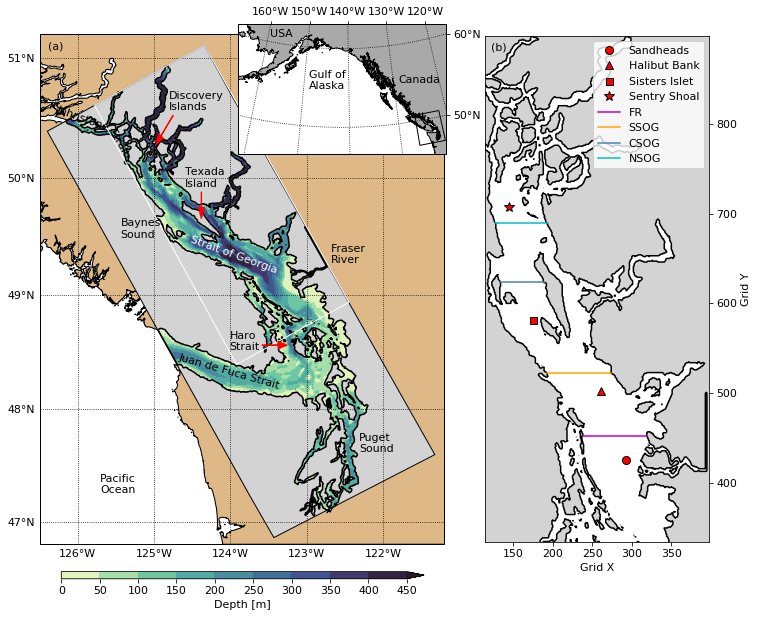

In [26]:
# Make figure
fig = plt.figure(figsize=(12, 10))
gs = plt.GridSpec(1, 2, width_ratios=[1.8, 1], wspace=0.13)

# ------------ Left Panel -------------------
# Map and projection
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=list(range(-127, -120)), ylocs=list(range(46, 53)))
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Overlay model domain
c = ax.contourf(
    lon, lat, bathy, levels=np.arange(0, 451, 50), cmap=cm.deep, extend='max', transform=crs.PlateCarree(), zorder=2,
)
ax.contourf(lon, lat, tmask, levels=[-0.01, 0.01], colors='lightgray', transform=crs.PlateCarree(), zorder=2)
ax.contour(lon, lat, tmask, levels=[-0.01, 0.01], colors='k', transform=crs.PlateCarree(), zorder=2)
for box, color in zip([(0, -1, 0, -1), [114, 397, 334, 897]], ['k', 'w']):
    xy = np.empty((4, 2))
    for n, i in zip(range(4), [(2, 0), (2, 1), (3, 1), (3, 0)]):
        xy[n, :] = lon[box[i[0]], box[i[1]]], lat[box[i[0]], box[i[1]]]
    ax.add_patch(Polygon(xy, fill=False, edgecolor=color, transform=crs.PlateCarree(), zorder=2))

# Annotations
ax.text(0.02, 0.97, '(a)', transform=ax.transAxes)
for ann in annotations:
    ax.text(*ann['xy'], ann['name'], transform=ax.transAxes, rotation=ann['r'], color=ann['c'])
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], head_width=0.015, edgecolor='r', facecolor='r', transform=ax.transAxes, zorder=2)
        
# ------------ Right Panel ------------------
# Plot subdomain and formatting
ax = fig.add_subplot(gs[1])
ax.contourf(tmask, levels=[-0.01, 0.01], colors='lightgray')
ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
ax.set_xlim(subdomain['ideal'][:2])
ax.set_ylim(subdomain['ideal'][2:])
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
viz_tools.set_aspect(ax)

# Overlay wind stations, sections, and annotations
for stn in stations: ax.plot(*stn['xy'], 'k'+stn['m'], markerfacecolor='r', markersize=stn['s'], label=stn['name'])
for sec in sections: ax.plot(sec['yx'][1], np.repeat(sec['yx'][0], 2), '-', color=sec['c'], label=sec['name'])
ax.text(0.03, 0.97, '(b)', transform=ax.transAxes)
ax.legend()

# ------------- Map Inset -------------------
# Map and projection
xmap, ymap = [-161, -122], [45, 62]
ax = fig.add_axes([0.355, 0.68, 0.24, 0.2], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax.set_extent(xmap + ymap)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray'))
xticks, yticks = list(range(-170, -100, 10)), list(range(40, 80, 10))
ax.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
fig.canvas.draw()
lct.lambert_xticks(ax, xticks)
lct.lambert_yticks(ax, yticks)

# Overlay labels and region box
ax.text(0.34, 0.50, 'Gulf of\nAlaska', transform=ax.transAxes)
ax.text(0.77, 0.55, 'Canada', transform=ax.transAxes)
ax.text(0.15, 0.90, 'USA', transform=ax.transAxes)
ax.add_patch(Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim)), int(np.diff(ylim)),
    transform=crs.PlateCarree(), fill=False, edgecolor='k', zorder=2,
))

# Add colorbar for model bathymetry
cax = fig.add_axes([0.15, 0.10, 0.42, 0.01])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

#fig.savefig('/home/bmoorema/Desktop/maps.pdf', bbox_inches='tight')

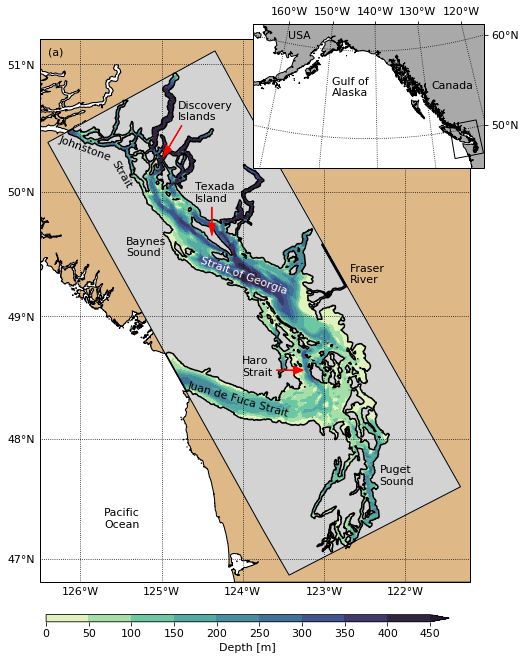

In [46]:
# Make figure
fig = plt.figure(figsize=(8, 10))

# ------------ Left Panel -------------------
# Map and projection
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
ax = fig.add_subplot(111, projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=list(range(-127, -120)), ylocs=list(range(46, 53)))
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Overlay model domain
c = ax.contourf(
    lon, lat, bathy, levels=np.arange(0, 451, 50), cmap=cm.deep, extend='max', transform=crs.PlateCarree(), zorder=2,
)
ax.contourf(lon, lat, tmask, levels=[-0.01, 0.01], colors='lightgray', transform=crs.PlateCarree(), zorder=2)
ax.contour(lon, lat, tmask, levels=[-0.01, 0.01], colors='k', transform=crs.PlateCarree(), zorder=2)
box = (0, -1, 0, -1)
xy = np.empty((4, 2))
for n, i in zip(range(4), [(2, 0), (2, 1), (3, 1), (3, 0)]):
    xy[n, :] = lon[box[i[0]], box[i[1]]], lat[box[i[0]], box[i[1]]]
ax.add_patch(Polygon(xy, fill=False, edgecolor='k', transform=crs.PlateCarree(), zorder=2))

# Annotations
ax.text(0.02, 0.97, '(a)', transform=ax.transAxes)
for ann in annotations:
    ax.text(*ann['xy'], ann['name'], transform=ax.transAxes, rotation=ann['r'], color=ann['c'])
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], head_width=0.015, edgecolor='r', facecolor='r', transform=ax.transAxes, zorder=2)

# ------------- Map Inset -------------------
# Map and projection
xmap, ymap = [-161, -122], [45, 62]
ax = fig.add_axes([0.51, 0.61, 0.4, 0.38], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax.set_extent(xmap + ymap)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray'))
xticks, yticks = list(range(-170, -100, 10)), list(range(40, 80, 10))
ax.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
fig.canvas.draw()
lct.lambert_xticks(ax, xticks)
lct.lambert_yticks(ax, yticks)

# Overlay labels and region box
ax.text(0.34, 0.50, 'Gulf of\nAlaska', transform=ax.transAxes)
ax.text(0.77, 0.55, 'Canada', transform=ax.transAxes)
ax.text(0.15, 0.90, 'USA', transform=ax.transAxes)
ax.add_patch(Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim)), int(np.diff(ylim)),
    transform=crs.PlateCarree(), fill=False, edgecolor='k', zorder=2,
))

# Add colorbar for model bathymetry
cax = fig.add_axes([0.15, 0.07, 0.7, 0.01])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/domain.pdf', bbox_inches='tight')

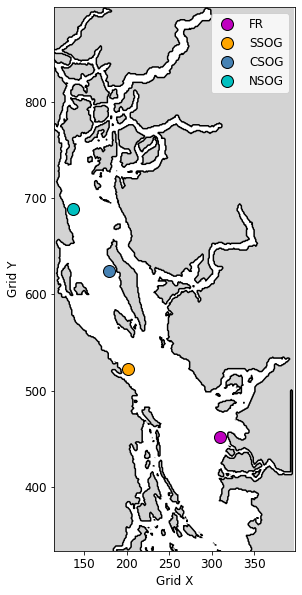

In [35]:
# Plot subdomain and formatting
fig, ax = plt.subplots(figsize=(6, 10))
ax.contourf(tmask, levels=[-0.01, 0.01], colors='lightgray')
ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
ax.set_xlim(subdomain['ideal'][:2])
ax.set_ylim(subdomain['ideal'][2:])
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
viz_tools.set_aspect(ax)

# Overlay wind stations, sections, and annotations
#for stn in stations: ax.plot(*stn['xy'], 'k'+stn['m'], markerfacecolor='r', markersize=stn['s']+2, label=stn['name'])
for sec, i in zip(sections, [72, 8, 46, 9]):
    ax.plot(sec['yx'][1][0]+i, sec['yx'][0], 'ko', markerfacecolor=sec['c'], label=sec['name'], markersize=12)
ax.legend()

fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/nitrate_stations.pdf', bbox_inches='tight')